In [1]:
import requests
from bs4 import BeautifulSoup
import json

In [17]:
# Function to extract course details
def extract_course_details(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract department
    department_tag = soup.find('span', string="Кафедра:")
    if department_tag:
        department = department_tag.find_next('a').text.strip()
    else:
        department = "Department information not available"

    # Extract lecturer
    lecturer_info = soup.find('td', class_='lecturer')
    if lecturer_info:
        lecturer_link_element = lecturer_info.find('a')
        if lecturer_link_element:  # Check if the <a> tag exists within lecturer_info
            lecturer = lecturer_link_element.text.strip()
            lecturer_link = lecturer_link_element['href']
        else:
            lecturer = "Lecturer information not available"
            lecturer_link = "No link available"
    else:
        lecturer = "Lecturer information not available"
        lecturer_link = "No link available"


    # Extract recommended literature
    literature_section = soup.find('section', class_='materials')
    if literature_section:  # Check if the literature_section is not None
        literature = [li.text.strip() for li in literature_section.find_all('li')]
    else:
        literature = ["No literature information available"]


    return {
        'department': department,
        'lecturer': {
            'name': lecturer,
            'link': lecturer_link,
        },
        'recommended_literature': literature,
    }

In [18]:
# Main URL (replace with the actual curriculum page containing course links)
main_url = 'https://kultart.lnu.edu.ua/academics/bachelor/curriculum-theatre-and-cinema'
main_response = requests.get(main_url)
main_soup = BeautifulSoup(main_response.content, 'html.parser')

# Extract all course links
course_links = [a['href'] for a in main_soup.select('td.title a') if 'course' in a['href']]

# Loop through each link and extract details
course_details = []
for link in course_links:
    details = extract_course_details(link)
    details['course_link'] = link  # Add the course link to details
    course_details.append(details)

# Save to JSON
with open('course_details.json', 'w', encoding='utf-8') as f:
    json.dump(course_details, f, ensure_ascii=False, indent=4)

In [10]:
base_url = 'https://kultart.lnu.edu.ua'
academics_url = f'{base_url}/academics/bachelor'
response = requests.get(academics_url)
soup = BeautifulSoup(response.content, 'html.parser')

specialties = soup.find_all('section', class_='specialization')
specialty_links = [base_url + spec.find('h3', class_='title').find('a')['href'] for spec in specialties]

In [13]:
from bs4 import BeautifulSoup

# Assuming `spec` is the BeautifulSoup object for the section containing the specialty
title_tag = [spec.find('h3', class_='title').find('a') for spec in specialties]
specialty_name = [title.text.strip() for title in title_tag]  # This removes leading/trailing whitespace

In [14]:
specialties_map = {
    spec.find('h3', class_='title').find('a').text.strip(): base_url + spec.find('h3', class_='title').find('a')['href'] 
    for spec in specialties
}

In [22]:
for index, spec_link in enumerate(specialty_links, start=1):
    main_response = requests.get(spec_link)
    main_soup = BeautifulSoup(main_response.content, 'html.parser')
    
    course_links = [a['href'] for a in main_soup.select('td.title a') if 'course' in a['href']]
    
    course_details = []
    for link in course_links:
        details = extract_course_details(link)
        details['course_link'] = link  # Add the course link to details
        course_details.append(details)

    # Use the index as part of the filename
    filename = f"specialty_{index}.json"
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(course_details, f, ensure_ascii=False, indent=4)

In [30]:
json_filenames = ['specialty_1.json', 'specialty_2.json', 'specialty_3.json', 'specialty_4.json','specialty_5.json', 'specialty_6.json', 'specialty_7.json']

# Initialize a list or a set to store aggregated literature entries
all_literature = list()

# Iterate over each JSON file to extract literature
for filename in json_filenames:
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
        for course in data:  # Assuming each file may contain multiple courses
            literature_entries = course.get('recommended_literature', [])
            all_literature.append(literature_entries)  # Use update() for a set to add items

In [34]:
from langdetect import detect

In [59]:
moskowian_counts = 0
Ukrainian_counts = 0
entries = 0

for sublist in all_literature:
    for entry in sublist:
        try:
            lang = detect(entry)
            if lang == 'uk':
                Ukrainian_counts += 1
            if lang == 'ru':
                moskowian_counts += 1
            entries += 1
        except Exception as e:
            continue


In [60]:
print(Ukrainian_counts, moskowian_counts)
print(f"Percentage of moscowian language on faculty of Culture and Arts: {round(moskowian_counts/entries * 100, 2)}")

11376 1612
Percentage of moscowian language on faculty of Culture and Arts: 11.52


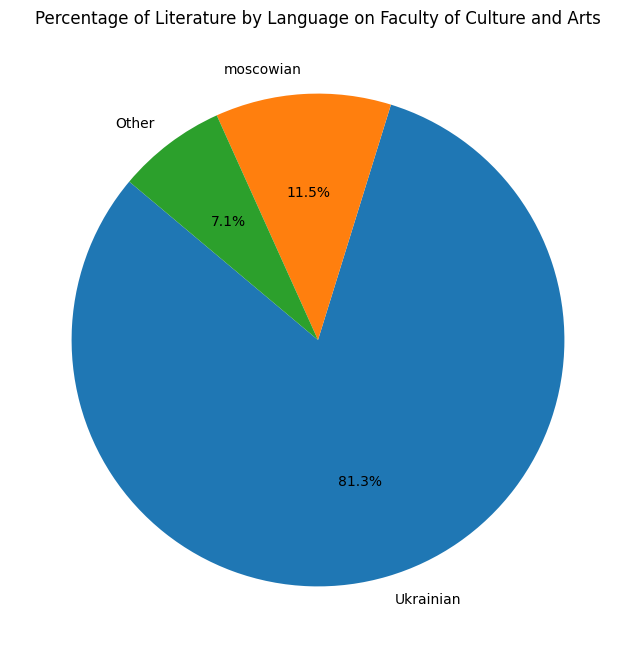

In [63]:
import matplotlib.pyplot as plt

# Data
languages = ['Ukrainian', 'moscowian', 'Other']
counts = [Ukrainian_counts, moskowian_counts, entries-Ukrainian_counts-moskowian_counts]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=languages, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Literature by Language on Faculty of Culture and Arts', fontsize=12)
plt.show()